# Lecture 10. Neural Networks for text

**Turning text into numbers**

Joaquin Vanschoren

In [1]:
# Global imports and settings
from preamble import *
import tensorflow as tf
import tensorflow.keras as keras
print("Using Keras",keras.__version__)
tf.compat.v1.disable_eager_execution()

%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using Keras 2.6.0


## Overview
* Bag of words representations
* Word embeddings
    * Learning word embeddings
    * Pretrained word embeddings
* 1D convolutional nets 
* In practice

## Bag of word representation
* First, build a _vocabulary_ of all occuring words. Maps every word to an index.
* Represent each document as an $N$ dimensional vector (top-$N$ most frequent words)
    * One-hot (sparse) encoding: 1 if the word occurs in the document
* Destroys the order of the words in the text (hence, a 'bag' of words)

<img src="../images/bag_of_words.png" alt="ml" style="width: 60%"/>

### Example: IMBD review database
* 50,000 reviews, labeled positive (1) or negative (0)
    * Every row (document) is one review, no other input features
    * Already tokenized. All markup, punctuation,... removed

In [2]:
from keras.datasets import imdb
word_index = imdb.get_word_index()
print("Text contains {} unique words".format(len(word_index)))

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(index_from=0)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

for r in [0,5,10]:
    print("\nReview {}:".format(r),' '.join([reverse_word_index.get(i, '?') for i in train_data[r]][0:50]))

Text contains 88584 unique words

Review 0: the this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved

Review 5: the begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br

Review 10: the french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one


#### Bag of words with one-hot-encoding
* Encoded review: shows the list of word IDs. Words are sorted by frequency of occurance.
    * Allows to easily remove the most common and least common words
* One-hot-encoded review: '1' if the word occurs. 
    * Only the first 100 of 10000 values are shown

In [3]:
# Custom implementation of one-hot-encoding. 
# dimension is the dimensionality of the output (default 10000).
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # create empty vector of length N
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data, dimension=len(word_index))
x_test = vectorize_sequences(test_data, dimension=len(word_index))

In [4]:
print("Review {}:".format(3),' '.join([reverse_word_index.get(i, '?') for i in train_data[3]][0:80]))
print("\nEncoded review: ", train_data[3][0:80])
print("\nOne-hot-encoded review: ", x_train[3][0:80])

Review 3: the the scots excel at storytelling the traditional sort many years after the event i can still see in my mind's eye an elderly lady my friend's mother retelling the battle of culloden she makes the characters come alive her passion is that of an eye witness one to the events on the sodden heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from

Encoded review:  [1, 1, 18606, 16082, 30, 2801, 1, 2037, 429, 108, 150, 100, 1, 1491, 10, 67, 128, 64, 8, 58, 15302, 741, 32, 3712, 758, 58, 5763, 449, 9211, 1, 982, 4, 64314, 56, 163, 1, 102, 213, 1236, 38, 1794, 6, 12, 4, 32, 741, 2410, 28, 5, 1, 684, 20, 1, 33926, 7336, 3, 3690, 39, 35, 36, 118, 56, 453, 7, 7, 4, 262, 9, 572, 108, 150, 156, 56, 13, 1444, 18, 22, 583, 479, 36]

One-hot-encoded review:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0

#### Word counts
* Count the number of times each word appears in the document
* Example using sklearn `CountVectorizer`
    * Here, we fit the Countvectorizer on just the first 2 reviews

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit count vectorizer on a few documents (here: 2)
line = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]][0:50]) for d in range(2)]
vect = CountVectorizer()
vect.fit(line)
print("Vocabulary (feature names) after fit:", vect.get_feature_names())

# Transform the data
# Returns a sparse matrix
X = vect.transform(line)
print("Count encoding doc 1:", X.toarray()[0])
print("Count encoding doc 2:", X.toarray()[1])

Vocabulary (feature names) after fit: ['actor', 'amazing', 'an', 'and', 'are', 'as', 'bad', 'be', 'being', 'best', 'big', 'boobs', 'brilliant', 'but', 'came', 'casting', 'cheesy', 'could', 'describe', 'direction', 'director', 'ever', 'everyone', 'father', 'film', 'from', 'giant', 'got', 'had', 'hair', 'horror', 'hundreds', 'imagine', 'is', 'island', 'just', 'location', 'love', 'loved', 'made', 'movie', 'movies', 'music', 'myself', 'norman', 'now', 'of', 'on', 'paper', 'part', 'pin', 'played', 'plot', 'really', 'redford', 'ridiculous', 'robert', 'safety', 'same', 'scenery', 'scottish', 'seen', 'so', 'story', 'suited', 'terrible', 'the', 'there', 'these', 'they', 'thin', 'this', 'to', 've', 'was', 'words', 'worst', 'you']
Count encoding doc 1: [1 1 1 2 0 1 0 0 2 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 2 1
 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 2 1 1 0 1 1 1 0 4 1 0 1 0 1 0 0
 1 0 0 1]
Count encoding doc 2: [0 0 0 3 1 0 1 1 0 1 2 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0

## Classification
* With this tabular representation, we can fit any model (e.g. Logistic regression)
* Visualize coefficients: which words are indicative for positive/negative reviews?

In [6]:
from sklearn.linear_model import LogisticRegressionCV

# Fit CountVectorizer on the first 5000 reviews 
data_size = 5000 # You can get a few % better in the full dataset, but takes longer
train_text = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]]) for d in range(data_size)]
test_text = [' '.join([reverse_word_index.get(i, '?') for i in test_data[d]]) for d in range(data_size)]

vect = CountVectorizer()
train_text_vec = vect.fit_transform(train_text)
test_text_vec = vect.transform(test_text)

lr = LogisticRegressionCV().fit(train_text_vec, train_labels[:data_size])
acc = lr.score(test_text_vec, test_labels[:data_size])
print("Logistic regression accuracy:",acc)

Logistic regression accuracy: 0.8542


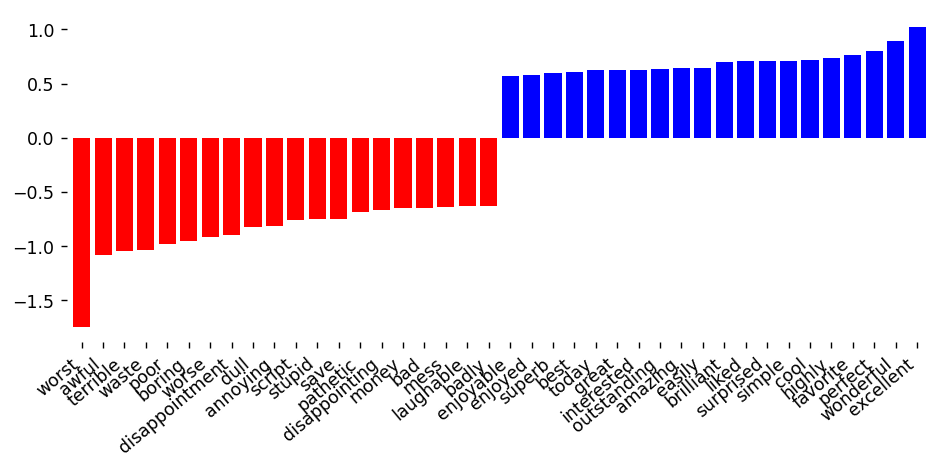

In [7]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)
plt.figure(figsize=(9, 3.5))
plot_important_features(lr.coef_.ravel(), np.array(vect.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()

### Preprocessing
* Tokenization: how to you split text into words? On spaces only? Also -, ` ? 
* Stemming: naive reduction to word stems. E.g. 'the meeting' to 'the meet'
    * Lemmatization: smarter reduction (NLP-based). E.g. distinguishes between nouns and verbs
* Discard stop words ('the', 'an',...)
* Only use $N$ (e.g. 10000) most frequent words
 * Or, use a hash function (risks collisions)
* n-grams: Use combinations of $n$ adjacent words next to individual words
    * e.g. 2-grams: "awesome movie", "movie with", "with creative", ...
* Character n-grams: combinations of $n$ adjacent letters: 'awe', 'wes', 'eso',...
* Useful libraries: [nltk](https://www.nltk.org/), [spaCy](https://spacy.io/), [gensim](https://radimrehurek.com/gensim/),...

### Scaling
* L2 Normalization (vector norm): sum of squares of all word values equals 1
    * Normalized Euclidean distance is equivalent to cosine distance
    * Works better for distance-based models (e.g. kNN, SVM,...)
$$ t_i = \frac{t_i}{\| t\|_2 }$$

* Term Frequency - Inverted Document Frequency (TF-IDF)
    * Scales value of words by how frequently they occur across all $N$ documents
    * Words that only occur in few documents get higher weight, and vice versa

$$ t_i = t_i \cdot log(\frac{N}{|\{d \in D : t_i \in d\}|})$$

* Usually done in preprocessing, e.g. sklearn `Normalizer` or `TfidfTransformer`
    * L2 normalization can also be done in a `Lambda` layer
```python
model.add(Lambda(lambda x: tf.linalg.normalize(x,axis=1)))
```

## Neural networks on bag of words representations
* We could build simple neural networks on bag-of-word vectors
    - E.g. One-hot-encoding, 10000 most frequent words, drop top-3 stopwords
* Simple model with 2 dense layers and ReLU activation
    - Binary classification: single output node: convert 0/1 label to float
    - Sigmoid activation for output node and binary cross-entropy loss
    
``` python
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
```

In [8]:
# Load data with 10000 words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# One-hot-encoding
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
# Callback for plotting
# TODO: move this to a helper file

from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
            
plot_losses = TrainingPlot()

### Model selection
* Take a validation set of 10,000 samples from the training set
* The validation loss peaks after a few epochs, after which the model starts to overfit
    * Performance is better than Logistic regression (obviously)

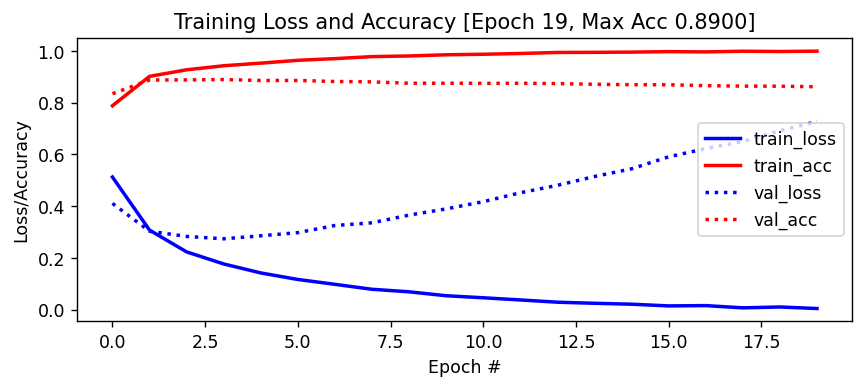

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Regularization: smaller networks
* The easiest way to avoid overfitting is to use a simpler model
    * E.g. use only 4 hidden nodes
* Less overfitting, but validation accuracy about the same

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))
smaller_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = smaller_model.fit(partial_x_train, partial_y_train,
                            epochs=20, batch_size=512, verbose=0,
                            validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Weight regularization (L2)
* L2 regularized model (on 16 hidden nodes) is equally/more resistant to overfitting, even though both have the same number of parameters
* Validation accuracy doesn't improve

```python
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu'))
```

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
l2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = l2_model.fit(partial_x_train, partial_y_train,
                       epochs=20, batch_size=512, verbose=0,
                       validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Dropout Regularization
* Overfits less than the original model, but more than L2-regularization

```python
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
```

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))
dpt_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = dpt_model.fit(partial_x_train, partial_y_train,
                        epochs=20, batch_size=512, verbose=0,
                        validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Tuning
* We can vary the remaining hyperparameters
    - Number of layers or hidden units, activation functions, optimizers, batch size, learning rates,...
* Quick grid search (using early stopping to select number of epochs):
    - We're not getting much better results using this representation

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

def make_model(hidden_size=16, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Dense(hidden_size, activation='relu', input_shape=(10000,)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(hidden_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = {'hidden_size': [8, 16, 64],
              'dropout_rate': [0.1, 0.25, 0.5]}
model = KerasClassifier(build_fn=make_model, epochs=10, verbose=0, validation_split=.2)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, refit='accuracy', return_train_score=True)
grid_search.fit(x_train, y_train, epochs=20, batch_size=512, 
                callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)]);

In [ ]:
res = pd.DataFrame(grid_search.cv_results_)
res.pivot_table(index=["param_hidden_size", "param_dropout_rate"],
                values=['mean_train_score', "mean_test_score"])

#### Predictions
Let's look at a few predictions:

In [ ]:
predictions = l2_model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

### Multi-class classification (topic classification)
* Reuters dataset: 11,000 news stories, 46 topics
* Each row is one news story
    * We again use the 10,000 most frequent words, and drop the top-3 stop words
* Each word is replaced by a _word index_ (word ID)

In [ ]:
from keras.datasets import reuters

# Default minimal index (to drop stop words) is 3
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

#### Building the network
* 16 hidden units may be too limited to learn 46 topics, hence we use 64
* The output layer now needs 46 units, one for each topic
    - We use `softmax` activation for the output to get probabilities
    - Loss function is now `categorical_crossentropy`
        - Hence, output labels need to be one-hot-encoded

``` python
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
```

#### Result
* Some overfitting after about 8 epochs
* Regularization may help, but let's try different representations

In [ ]:
# Preprocess data
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# Build model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Validation set
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

# Fit
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, verbose=0,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[plot_losses])

## Word Embeddings
* An embedding maps each word to a point in a much smaller $m$-dimensional space (e.g. 300 values)
* 2 main approaches:
    * Learn the embedding jointly with your main task.
        * Add an _embedding layer_ with $m$ hidden nodes to map word IDs to an $m$-dimensional vector
        * Add your hidden and output layers, learn weights end-to-end with SGD
    * Use a pre-trained embedding
        * Usually trained on another, much bigger task (e.g. Wikipedia, Google News,...)
        * Freeze embedding weights to produce simple word embeddings, or finetune to a new tasks

### Training Embedding layers
* Input layer uses fixed length documents. E.g. 100 nodes for 100 word IDs
    * Pad with 0's if docuyment is shorter. 2D tensor of shape (samples, max_length)
* Add an _embedding layer_ to learn the embedding
    * First represents every word as an $n$-dimensional one-hot encoded bag of words. 
        * Reshapes 2D tensor to 3D tensor of shape (samples, max_length, $n$)
    * To learn an $m$-dimensional embedding, use $m$ hidden nodes
        * Learn weight matrix $W^{n x m}$: maps one-hot-encoded word to embedding
    * Uses a linear activation function: $\mathbf{X}_{embed} = W \mathbf{X}_{orig}$
        * Outputs a 3D tensor of shape (samples, max_length, $m$)
* Add layers to map word embeddings to the desired output (see later)
* Learn all weights from the labeled data.

### Pre-trained embeddings
* With more data we can build better embeddings, but we also need more labels
* Solution: learn embedding on auxiliary task that doesn't require labels 
    * E.g. given a word, predict the surrounding words.
    * Also called self-supervised learning. Supervision is provided by data itself
* Most common approaches:
    * Word2Vec: Learn neural embedding for a word based on surrounding words
        * Encoding is learned using a 1-layer neural net
    * GloVe (Global Vector): Count co-occurrences of words in a matrix
        * Use a low-rank approximation to get a condensed vector representation
    * FastText: learns embedding for character n-grams
        * Can also produce embeddings for new, unseen words
    * Language models (BERT, ELMO, GPT3,...): learn a context-dependent embedding
        * Words get different embeddings based on the sentence they appear in

#### Word2Vec
- Move a window over text to get $C$ context words ($V$-dim one-hot encoded)
- Add hidden layer with $N$ linear nodes, average pooling, and softmax layer(s)
- CBOW: predict word given context, use weights of last layer as embedding
- Skip-Gram: predict context given word, use weights of first layer as embedding (better for large corpora)

<img src="../images/09_word_embeddings_3.png" alt="ml" style="width: 600px;"/>

#### Word2Vec properties
* Word2Vec happens to learn [interesting relationships](https://www.aclweb.org/anthology/N13-1090/) between words
    * Simple vector arithmetic can map words to plurals, conjugations, gender analogies,...
    * e.g. Gender relationships: $vec_{king} - vec_{man} + vec_{woman} \sim vec_{queen}$ 
    * PCA applied to embeddings shows Country - Capital relationship
* Careful: embeddings can capture [gender and other biases](https://arxiv.org/abs/1607.06520) present in the data.
    * Important unsolved problem!

<img src="../images/word2vec.png" alt="ml" style="width: 800px;"/>

#### FastText
* Limitations of Word2Vec:
    * Cannot represent new (out-of-vocabulary) words
    * Words like 'meet' and 'meeting' are learned independently: less efficient (no parameter sharing)
* FastText addresses this by using character n-grams
    * Basic model can be Skip-gram or CBOW
    * Words are represented by all character n-grams of length 3 to 6
        * "football" 3-grams: <fo, foo, oot, otb, tba, bal, all, ll>
        * Because there are so many n-grams, they are hashed
            * Dimensionality V = bin size
        * Representation of word "football" is sum of its n-gram embeddings
* Training with positive examples (in-context words) and random negative examples  

#### Global Vector model (GloVe)
* Builds a co-occurence matrix $\mathbf{X}$
    * Counts how often 2 words occur in the same context (and how close)
* Learns a k-dimensional embedding $w$ through matrix factorization with rank k
    * Actually learns 2 embeddings $w$ and $w'$ (differ in random initialization)
* Minimizes loss $\mathcal{L}$, where $b_i$ and $b'_i$ are bias terms and $f$ is a weighting function

$$\mathcal{L} = \sum_{i,j=1}^{V} f(\mathbf{X}_{ij}) (\mathbf{w_i} \mathbf{w'_j} + b_i + b'_j - log(\mathbf{X}_{ij}))^2$$

<img src="../images/glove3.png" alt="ml" style="width: 800px;"/>

### Document/paragraph embeddings
* Simplest approach to represent a document: sum or average of all word vectors
* Doc2Vec 
    * Next to word embeddings, also learn an embedding for the document/paragraph
    * Acts as a memory that remembers what is missing from the current context (the topic of the paragraph)
    * Can be used to determine semantic similarity between documents. 
    * Can be tricky to train.
    
<img src="../images/doc2vec.png" alt="ml" style="width:600px;"/>

## Using word embeddings
* Say that we have m-dimensional word embeddings and documents of size $l$
* Our embedding layer will produce a 3D tensor of shape (samples, $l$, $m$)
* We now need to map this to the desired output
    * Simply flattening the tensor learns a direct mapping. This destroys the word order.
    * A recurrent neural network (RNN) could leverage the exact sequence of the words
        * Can be slow to train
    * A 1D convolutional network can also leverage locality (learn local patterns)
        * Often competitive with RNNs, and much faster/cheaper
        * Works well for simple tasks like classification and forecasting

## 1D convolutional networks
* Similar to 2D convnets, 1D convnets extract local 1D patches from image tensors
    * Apply identical transformation (filter) to every patch 
* Pattern learned can later be recognized elsewhere (translation invariance)
* 1D Pooling: extracts 1D patches and outputs the max value (max pooling) or average

<img src="../images/1Dconvnet.png" alt="ml" style="width:500px;"/>

## Neural network for text in practice
### Training embedding layers
* Simple model with an embedding layer and direct mapping to binary class

```python
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 8 # embedding length (more would be better)

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 16 # embedding length

# define the model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

* Training on the IMDB dataset

In [ ]:
from keras import preprocessing

# Load reviews again
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Turn word ID's into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

model.fit(x_train, y_train, epochs=10, verbose=0,
          batch_size=32, validation_split=0.2, callbacks=[plot_losses]);

### Using pretrained embeddings
* Download the [raw 20 newsgroups dataset](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20)
    * 20,000 message board messages belonging to 20 different topic categories
* Preprocess the data by appending all files and vectorize it using Keras' `TextVectorization` layer
    * Lowercasing, punctuation removal, tokenization, indexing, integer encoding (or TFIDF)
* Download the [GloVe embeddings trained on Wikipedia](https://nlp.stanford.edu/projects/glove) (800MB!)
* Build an embedding matrix of shape (max_words, embedding_dim) that we can load into an embedding layer

```python
embedding_layer = layers.Embedding(
    num_tokens, # 20000
    embedding_dim, # 100
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # GloVe embedding
    trainable=False, # Freeze the pretrained weights
)
```

In [ ]:
# Uncomment when running the first time
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
!wget http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz
!tar -xf news20.tar.gz

In [ ]:
import os

# Get raw training data
data_dir = './20_newsgroup'
dirnames = os.listdir(data_dir)
fnames = os.listdir(data_dir + "/comp.graphics")

samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir + "/" + dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath + "/" + fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.95
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

# Vectorize the data. Takes a while!
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
embeddings_index = {}
glove_dir = "./"
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
num_tokens = 4000002 #len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

### Conv1D model
* First layer produces the word embeddings
* Three 1D convolutional layers with MaxPooling
* One dense layer with dropout
* Output later (20 classes) with softmax activation

```python
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation="softmax"))
```

In [ ]:
keras.backend.clear_session() 

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

model = models.Sequential()
model.add(layers.Input(shape=(None,), dtype="int64"))
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation="softmax"))
model.summary()

#### Training

In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val), callbacks=[plot_losses])

### Using 1D convnets on IMDB data
* Let's try to learn a self-learned embedding with 1D convolutional layers
* A lot better than the previous self-trained embeddings. Worse that using the pretrained embeddings.
* Start overfitting after a few epochs.
* Try using the pretrained embeddings together with 1D convolutional layers :)

```python
model = Sequential()
model.add(layers.Embedding(10000, 128, input_length=100))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
```

#### Results

In [ ]:
max_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

model = models.Sequential()
model.add(layers.Embedding(max_words, 128, input_length=max_length))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[plot_losses])

## Summary
* Bag of words representations
    * Useful, but limited, since they destroy the order of the words in text
* Word embeddings
    * Learning word embeddings from labeled data is hard, you may need a lot of data
    * Pretrained word embeddings
        * Word2Vec: learns good embeddings and interesting relationships
        * FastText: can also compute embeddings for entirely new words
        * GloVe: also takes the global context of words into account
        * Language models: state-of-the-art, but expensive
* 1D convolutional nets 
    * Allow us to use the sequence of the words in text, cheaper than RNNs
* In practice
    * Using pretrained embeddings gives great performance
        * Embedding weights can be frozen or finetuned to the task at hand
    * 1D convnets can be used to learn decent embeddings for a given task